**Materia: Visión por Computadora 1**

Alumno: Ezequiel Alejandro Caamaño

Cohorte: 18va.

Trabajo Práctico Nro. 2

Objetivo:
Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan lascámaras digitales modernas. El video a procesar será: “focus_video.mov”.
1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper"ImageSharpnessMeasureforBlurredImagesin FrequencyDomain“ y realizar tres experimentos:
1. Medición sobre todo el frame.
2.Medición sobre una ROI ubicada en el centro del frame. Areade la ROI = 5 o 10% del areatotal del frame.
Para cada experimento se debe presentar :
-
Una curva o varias curvas que muestren la evolución de la métrica framea framedonde se vea claramente cuando el algoritmo detecto el punto de máximo enfoque.
1. Medicion de foco en toda la imagen
El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática.

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift
import os
from google.colab import drive
from IPython.display import display, Image

drive.mount('/content/drive')

video_path = "/content/drive/MyDrive/VC1/TP2/focus_video.mov"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Función para calcular la nitidez. La metrica se basa en el espectro de frecuencia normalizado.

In [15]:
def calculate_sharpness_metric(image):

    # Convertir a escala de grises si es necesario
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Aplicar FFT
    f = fft2(gray)
    fshift = fftshift(f)
    magnitude_spectrum = np.abs(fshift)

    # Calcular la energía total del espectro
    total_energy = np.sum(magnitude_spectrum)

    # Normalizar el espectro
    if total_energy > 0:  # Prevenir división por cero
        normalized_spectrum = magnitude_spectrum / total_energy
    else:
        return 0.0

    # Crear una máscara de distancia al centro
    rows, cols = gray.shape
    center_row, center_col = rows // 2, cols // 2
    y, x = np.ogrid[-center_row:rows-center_row, -center_col:cols-center_col]
    dist_from_center = np.sqrt(x*x + y*y)

    # Calcular la métrica (mayor peso a las altas frecuencias)
    sharpness = np.sum(normalized_spectrum * dist_from_center)

    return sharpness

Se procesa el video para obtener la nitidez de cada frame.

In [16]:


def process_video(video_path, roi_percentage=None, visualize_frames=False, display_interval=30):

    # Verificar que el archivo existe
    if not os.path.exists(video_path):
        print(f"ERROR: El archivo '{video_path}' no existe. Verifica la ruta.")
        return []

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error al abrir el video: {video_path}")
        return []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    print(f"Información del video:")
    print(f"- Dimensiones: {width}x{height}")
    print(f"- FPS: {fps}")
    print(f"- Total frames: {total_frames}")
    print(f"- Duración estimada: {total_frames/fps:.2f} segundos")

    sharpness_values = []
    frame_count = 0

    saved_frames = {}

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1

        if roi_percentage is not None:

            height, width = frame.shape[:2]
            roi_size = int(np.sqrt((roi_percentage / 100) * height * width))

            start_y = (height - roi_size) // 2
            start_x = (width - roi_size) // 2

            roi = frame[start_y:start_y + roi_size, start_x:start_x + roi_size]

            frame_with_roi = frame.copy()
            cv2.rectangle(frame_with_roi,
                         (start_x, start_y),
                         (start_x + roi_size, start_y + roi_size),
                         (0, 255, 0), 2)

            sharpness = calculate_sharpness_metric(roi)

            if visualize_frames and frame_count % display_interval == 0:
                saved_frames[frame_count] = frame_with_roi

        else:
            sharpness = calculate_sharpness_metric(frame)

            if visualize_frames and frame_count % display_interval == 0:
                saved_frames[frame_count] = frame

        sharpness_values.append(sharpness)

        if frame_count % 10 == 0 or frame_count == total_frames:
            print(f"Procesados {frame_count}/{total_frames} frames ({frame_count/total_frames*100:.1f}%)")

    cap.release()

    # Visualizar algunos frames guardados
    if visualize_frames and saved_frames:
        plt.figure(figsize=(15, 10))
        count = min(5, len(saved_frames))
        frames_to_show = list(saved_frames.keys())
        frames_to_show.sort()
        frames_to_show = frames_to_show[:count]

        for i, frame_num in enumerate(frames_to_show):
            plt.subplot(1, count, i+1)
            plt.imshow(cv2.cvtColor(saved_frames[frame_num], cv2.COLOR_BGR2RGB))
            plt.title(f"Frame {frame_num}\nNitidez: {sharpness_values[frame_num-1]:.4f}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    return sharpness_values

Función para graficar curva de nitidez y detectar punto de mayor enfoque

In [17]:


def plot_sharpness_curve(sharpness_values, title, save_path=None):

    max_idx = np.argmax(sharpness_values)

    plt.figure(figsize=(12, 6))
    plt.plot(sharpness_values)
    plt.scatter(max_idx, sharpness_values[max_idx], color='red', s=100, zorder=5)

    plt.title(title)
    plt.xlabel('Número de Frame')
    plt.ylabel('Métrica de Nitidez')
    plt.grid(True)

    plt.annotate(f'Máximo Enfoque\nFrame {max_idx+1}\nValor: {sharpness_values[max_idx]:.4f}',
                xy=(max_idx, sharpness_values[max_idx]),
                xytext=(max_idx + 10, sharpness_values[max_idx]),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)

    plt.show()

    return max_idx

Se extrae el frame y se devuelve como imagen

In [18]:


def extract_frame_from_video(video_path, frame_number):

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error al abrir el video: {video_path}")
        return None

    # Establecer la posición del frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number - 1)

    ret, frame = cap.read()
    cap.release()

    if not ret:
        print(f"Error al extraer el frame {frame_number}")
        return None

    return frame

def visualize_max_focus_frames(video_path, max_frames, roi_percentages=None):

    plt.figure(figsize=(15, 10))

    for i, (key, frame_idx) in enumerate(max_frames.items()):

        frame = extract_frame_from_video(video_path, frame_idx + 1)  # +1 porque los frames empiezan en 0

        if frame is None:
            continue

        if roi_percentages and roi_percentages[i] is not None:
            height, width = frame.shape[:2]
            roi_size = int(np.sqrt((roi_percentages[i] / 100) * height * width))
            start_y = (height - roi_size) // 2
            start_x = (width - roi_size) // 2
            cv2.rectangle(frame,
                         (start_x, start_y),
                         (start_x + roi_size, start_y + roi_size),
                         (0, 255, 0), 2)

        plt.subplot(1, len(max_frames), i+1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f"{key}\nFrame {frame_idx+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Se ejecutan los experimentos y se muestran las visualizaciones.



Experimento 1: Medición sobre todo el frame
Información del video:
- Dimensiones: 640x360
- FPS: 29.97002997002997
- Total frames: 171
- Duración estimada: 5.71 segundos
Procesados 10/171 frames (5.8%)
Procesados 20/171 frames (11.7%)
Procesados 30/171 frames (17.5%)
Procesados 40/171 frames (23.4%)
Procesados 50/171 frames (29.2%)
Procesados 60/171 frames (35.1%)
Procesados 70/171 frames (40.9%)
Procesados 80/171 frames (46.8%)
Procesados 90/171 frames (52.6%)
Procesados 100/171 frames (58.5%)
Procesados 110/171 frames (64.3%)
Procesados 120/171 frames (70.2%)
Procesados 130/171 frames (76.0%)
Procesados 140/171 frames (81.9%)
Procesados 150/171 frames (87.7%)
Procesados 160/171 frames (93.6%)
Procesados 170/171 frames (99.4%)
Procesados 171/171 frames (100.0%)


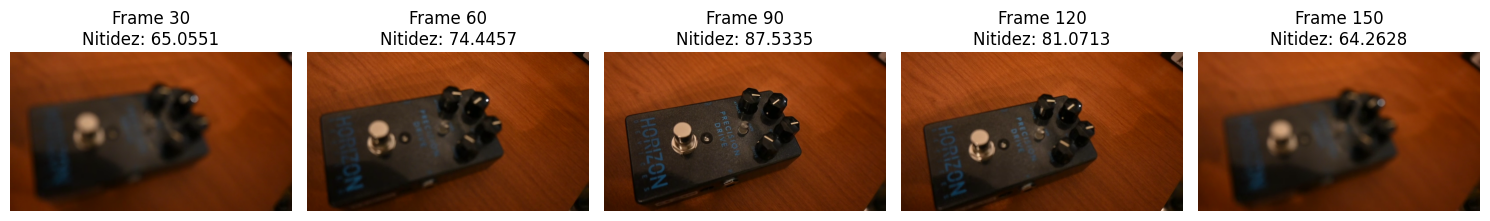



Experimento 2: Medición sobre ROI del 5%
Información del video:
- Dimensiones: 640x360
- FPS: 29.97002997002997
- Total frames: 171
- Duración estimada: 5.71 segundos
Procesados 10/171 frames (5.8%)
Procesados 20/171 frames (11.7%)
Procesados 30/171 frames (17.5%)
Procesados 40/171 frames (23.4%)
Procesados 50/171 frames (29.2%)
Procesados 60/171 frames (35.1%)
Procesados 70/171 frames (40.9%)
Procesados 80/171 frames (46.8%)
Procesados 90/171 frames (52.6%)
Procesados 100/171 frames (58.5%)
Procesados 110/171 frames (64.3%)
Procesados 120/171 frames (70.2%)
Procesados 130/171 frames (76.0%)
Procesados 140/171 frames (81.9%)
Procesados 150/171 frames (87.7%)
Procesados 160/171 frames (93.6%)
Procesados 170/171 frames (99.4%)
Procesados 171/171 frames (100.0%)


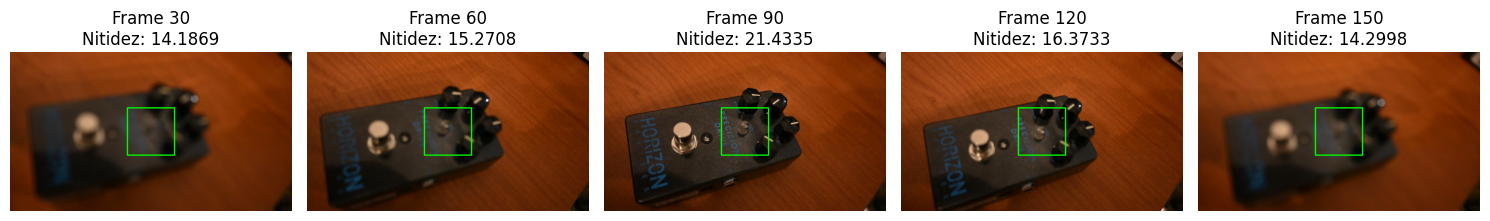



Experimento 3: Medición sobre ROI del 10%
Información del video:
- Dimensiones: 640x360
- FPS: 29.97002997002997
- Total frames: 171
- Duración estimada: 5.71 segundos
Procesados 10/171 frames (5.8%)
Procesados 20/171 frames (11.7%)
Procesados 30/171 frames (17.5%)
Procesados 40/171 frames (23.4%)
Procesados 50/171 frames (29.2%)
Procesados 60/171 frames (35.1%)
Procesados 70/171 frames (40.9%)
Procesados 80/171 frames (46.8%)
Procesados 90/171 frames (52.6%)
Procesados 100/171 frames (58.5%)
Procesados 110/171 frames (64.3%)
Procesados 120/171 frames (70.2%)
Procesados 130/171 frames (76.0%)
Procesados 140/171 frames (81.9%)
Procesados 150/171 frames (87.7%)
Procesados 160/171 frames (93.6%)
Procesados 170/171 frames (99.4%)
Procesados 171/171 frames (100.0%)


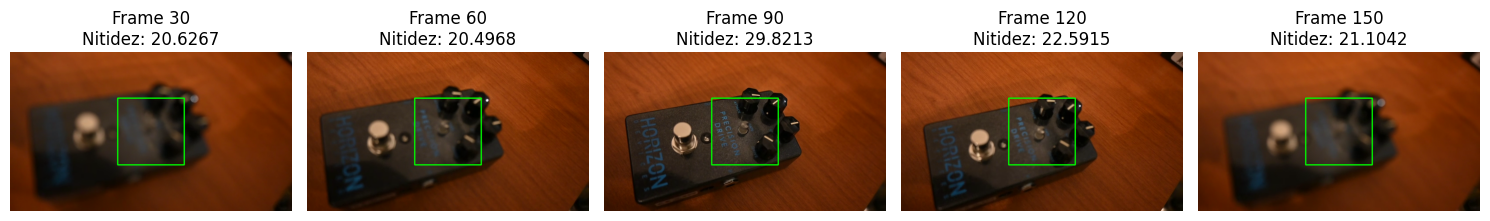



Analizando resultados y generando gráficas


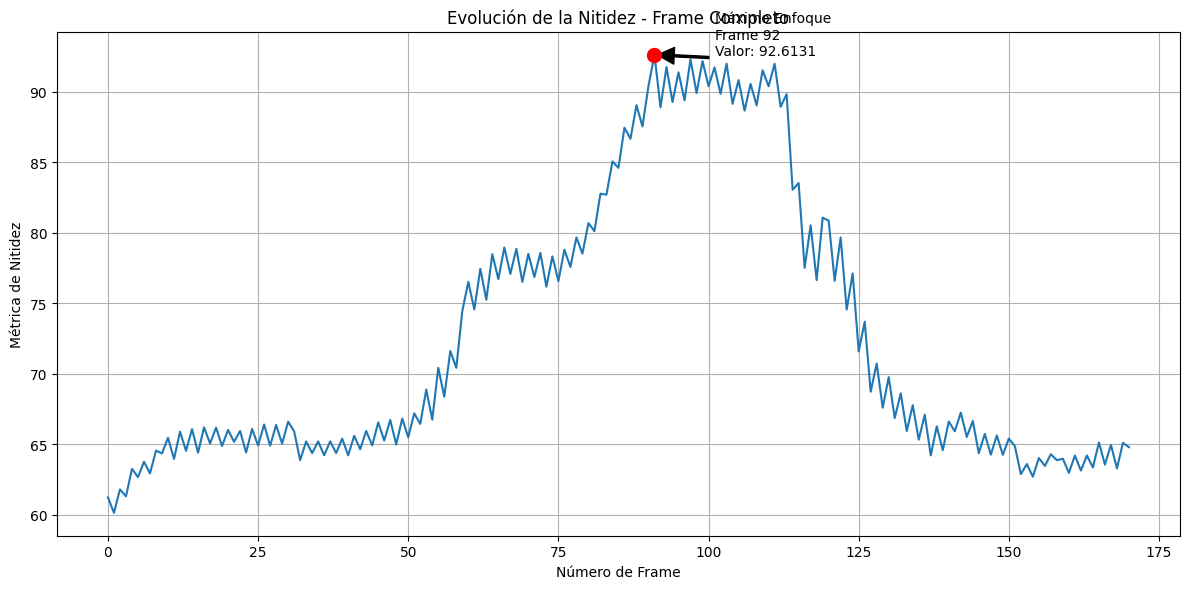

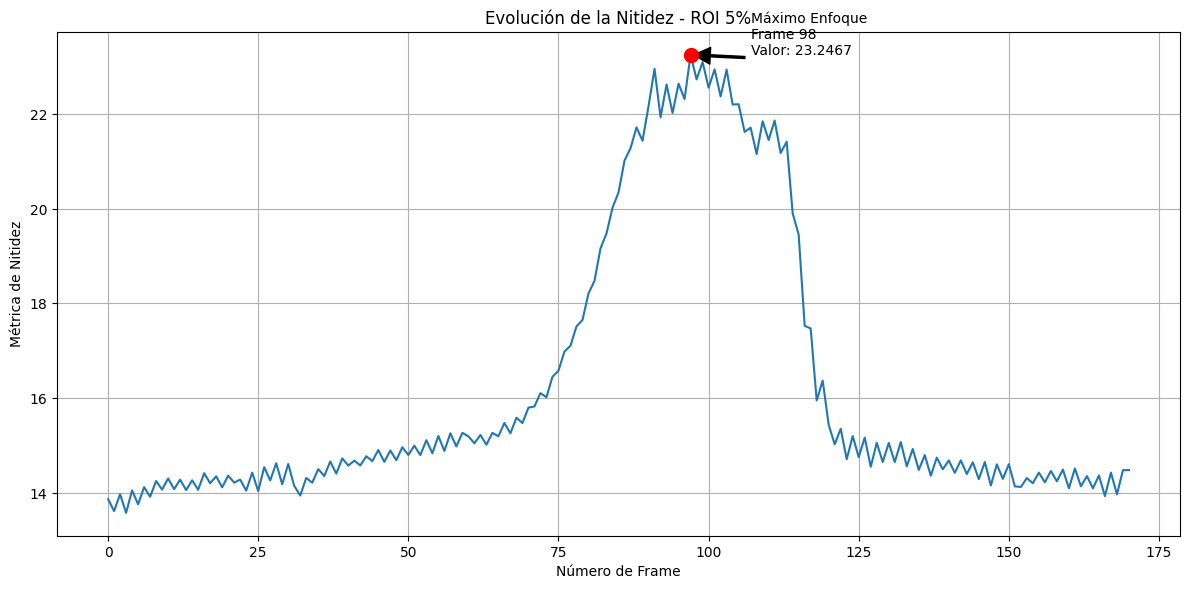

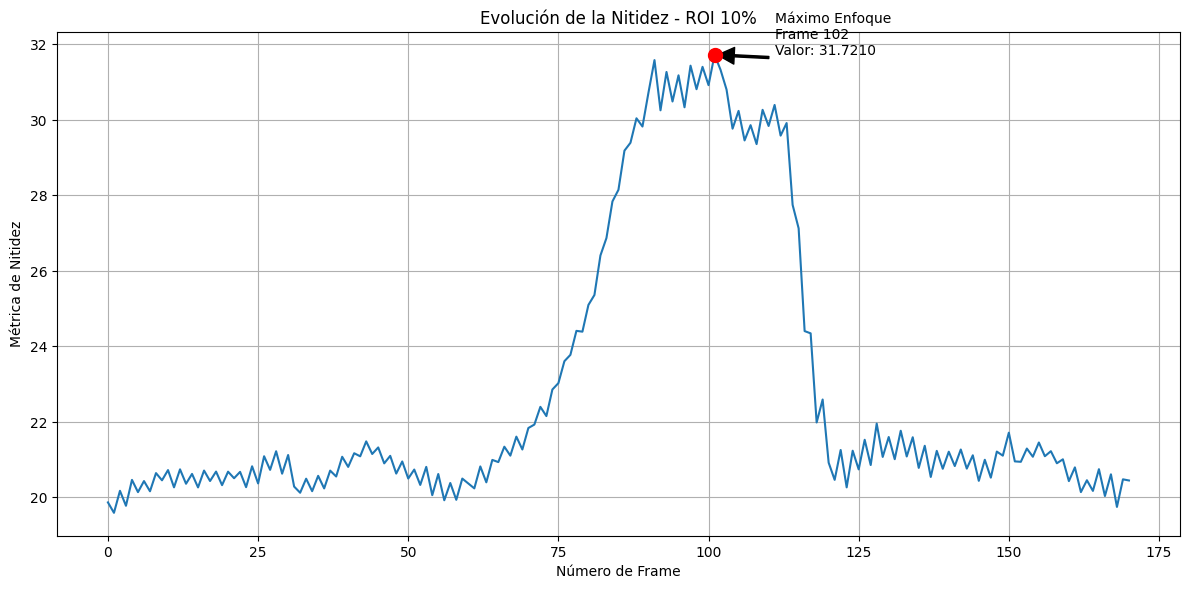

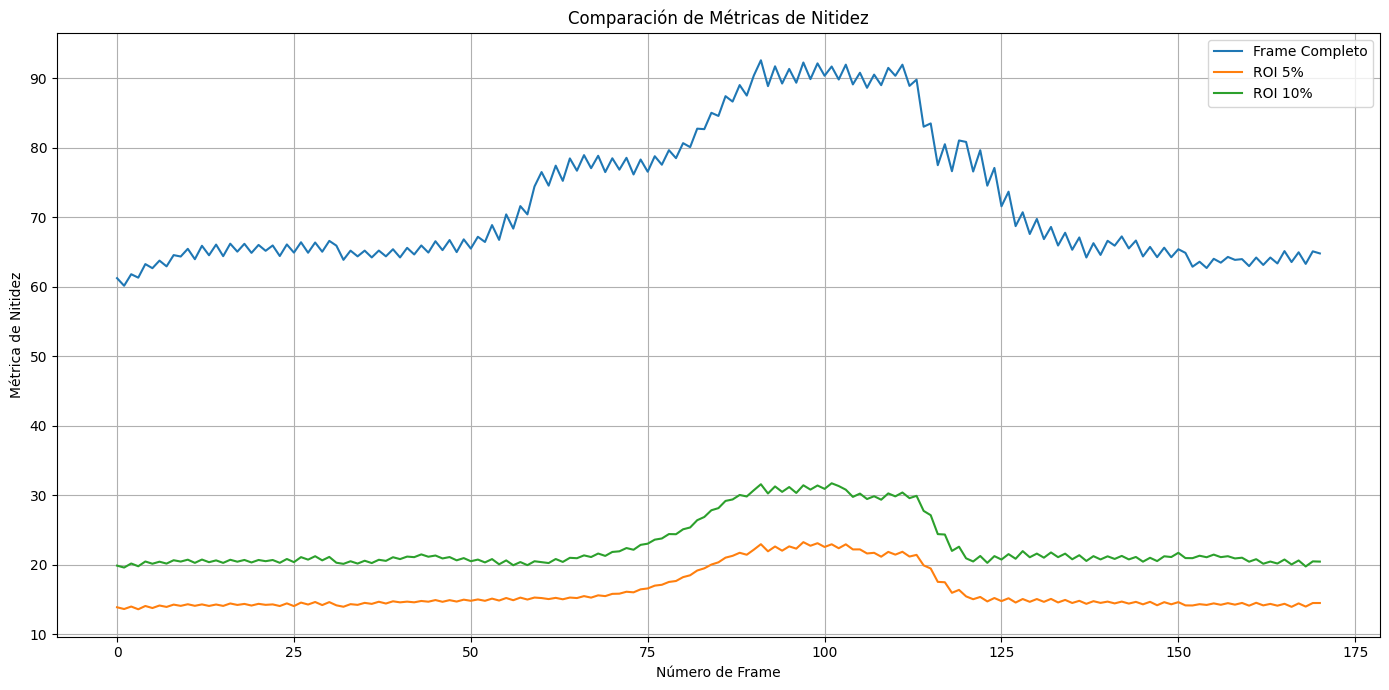

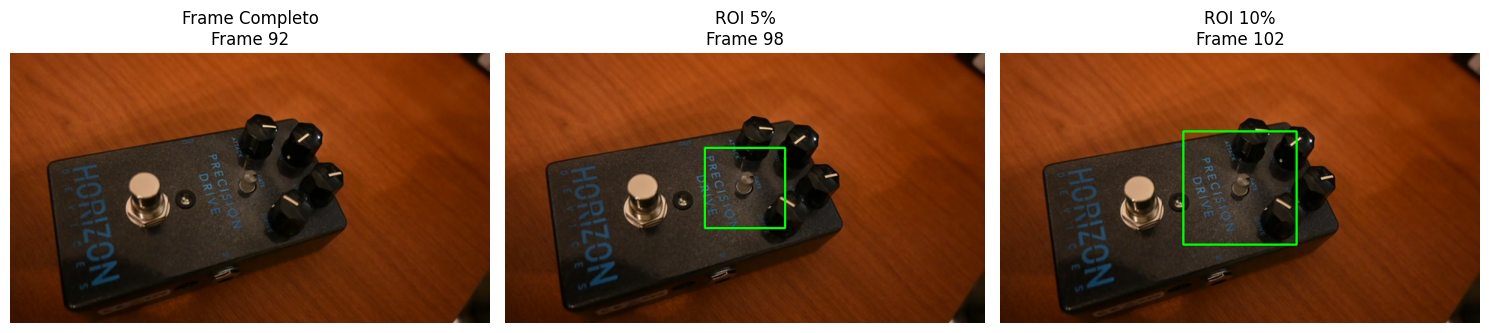


Resultados:
Frame de máximo enfoque (Frame Completo): 92
Frame de máximo enfoque (ROI 5%): 98
Frame de máximo enfoque (ROI 10%): 102

Resultados guardados en carpeta: resultados_detector_enfoque


In [19]:

def run_experiments(video_path, results_dir="resultados_detector_enfoque"):

    # Crear carpeta para resultados si no existe
    os.makedirs(results_dir, exist_ok=True)

    # Experimento 1: Medición sobre todo el frame
    print("\n\n==========================================")
    print("Experimento 1: Medición sobre todo el frame")
    print("==========================================")
    sharpness_full = process_video(video_path, visualize_frames=True)

    # Experimento 2: Medición sobre ROI del 5%
    print("\n\n==========================================")
    print("Experimento 2: Medición sobre ROI del 5%")
    print("==========================================")
    sharpness_roi_5 = process_video(video_path, roi_percentage=5, visualize_frames=True)

    # Experimento 3: Medición sobre ROI del 10%
    print("\n\n==========================================")
    print("Experimento 3: Medición sobre ROI del 10%")
    print("==========================================")
    sharpness_roi_10 = process_video(video_path, roi_percentage=10, visualize_frames=True)

    # Graficar y guardar resultados individuales
    print("\n\n==========================================")
    print("Analizando resultados y generando gráficas")
    print("==========================================")

    max_frame_completo = plot_sharpness_curve(sharpness_full,
                                        "Evolución de la Nitidez - Frame Completo",
                                        os.path.join(results_dir, "nitidez_frame_completo.png"))

    max_frame_roi_5 = plot_sharpness_curve(sharpness_roi_5,
                                     "Evolución de la Nitidez - ROI 5%",
                                     os.path.join(results_dir, "nitidez_roi_5.png"))

    max_frame_roi_10 = plot_sharpness_curve(sharpness_roi_10,
                                      "Evolución de la Nitidez - ROI 10%",
                                      os.path.join(results_dir, "nitidez_roi_10.png"))

    # Graficar todos los resultados juntos para comparación
    plt.figure(figsize=(14, 7))
    plt.plot(sharpness_full, label='Frame Completo')
    plt.plot(sharpness_roi_5, label='ROI 5%')
    plt.plot(sharpness_roi_10, label='ROI 10%')

    plt.title("Comparación de Métricas de Nitidez")
    plt.xlabel('Número de Frame')
    plt.ylabel('Métrica de Nitidez')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "comparacion_metricas.png"))
    plt.show()

    # Guardar los datos
    np.savez(os.path.join(results_dir, "datos_nitidez.npz"),
             frame_completo=sharpness_full,
             roi_5=sharpness_roi_5,
             roi_10=sharpness_roi_10)

    # Mostrar los frames de máximo enfoque
    max_frames = {
        'Frame Completo': max_frame_completo,
        'ROI 5%': max_frame_roi_5,
        'ROI 10%': max_frame_roi_10
    }

    roi_percentages = [None, 5, 10]

    visualize_max_focus_frames(video_path, max_frames, roi_percentages)

    print("\nResultados:")
    print(f"Frame de máximo enfoque (Frame Completo): {max_frame_completo+1}")
    print(f"Frame de máximo enfoque (ROI 5%): {max_frame_roi_5+1}")
    print(f"Frame de máximo enfoque (ROI 10%): {max_frame_roi_10+1}")

    # Guardar un informe de texto con los resultados
    with open(os.path.join(results_dir, "informe_resultados.txt"), "w") as f:
        f.write("INFORME DE RESULTADOS - DETECTOR DE MÁXIMO ENFOQUE\n")
        f.write("================================================\n\n")
        f.write(f"Frame de máximo enfoque (Frame Completo): {max_frame_completo+1}\n")
        f.write(f"Valor de nitidez: {sharpness_full[max_frame_completo]:.4f}\n\n")
        f.write(f"Frame de máximo enfoque (ROI 5%): {max_frame_roi_5+1}\n")
        f.write(f"Valor de nitidez: {sharpness_roi_5[max_frame_roi_5]:.4f}\n\n")
        f.write(f"Frame de máximo enfoque (ROI 10%): {max_frame_roi_10+1}\n")
        f.write(f"Valor de nitidez: {sharpness_roi_10[max_frame_roi_10]:.4f}\n")

    print(f"\nResultados guardados en carpeta: {results_dir}")

    return {
        'frame_completo': sharpness_full,
        'roi_5': sharpness_roi_5,
        'roi_10': sharpness_roi_10,
        'max_frames': max_frames
    }

results = run_experiments(video_path)


plt.show()